In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
from tqdm.notebook import tqdm, trange
import pickle as pkl

%load_ext autoreload
%autoreload 2

from utils import *
from bs_helpers import *

In [2]:
# Erstellt August 2020
# (c) mha

def create_sea_ships(seed=None):
    'Creates a sea with random ships on it'
    rng = random.Random(seed)
    sea = np.zeros((10,10))
    ships = np.zeros((10,10,4)) # extra information which kind of ship is where
    for k, l in enumerate([5,4,3,2]): # Länge
        n = 6-l # Anzahl
        for _ in range(n):
            # Boot mit Länge l platzieren
            while True:
                t = rng.random() < 0.5
                if t:
                    sea = sea.T # Transponieren
                    ships = ships.transpose(1,0,2)
                px = rng.randint(0, 10-l)
                py = rng.randint(0, 9)
                if sum(sea[px:px+l,py]) > 0:
                    continue
                sea[px:px+l, py] = 1
                ships[px:px+l, py, k] = 1
                if t:
                    sea = sea.T # Transponieren
                    ships = ships.transpose(1,0,2)
                break
    return sea, ships

def visualize(sea, detection):
    'Erstellt eine Veranschaulichung, 0 bzw. 4 sind detektiertes Wasser bzw. Schiff, 1 und 2 sind undetektiert.'
    return sea + sea*detection + 1 - ((1-sea)*detection)

def plot_sea(sea, det, ax=None):
    if ax is None: ax = plt.gca()
    #ax.imshow(visualize(sea, det), vmin=-2, cmap='plasma')
    ax.imshow(visualize(sea, det), vmin=-1, vmax=3.15, cmap='cividis')
    ax.axis('off')

In [3]:
from numba import njit, jit

@njit(cache=True)
def njit_create_sea():
    'Creates a sea with random ships on it'
    sea = np.zeros((10,10))
    for l in [5,4,3,2]: # Länge
        n = 6-l # Anzahl
        for _ in range(n):
            # Boot mit Länge l platzieren
            while True:
                t = np.random.rand() < 0.5
                if t: sea = sea.T # Transponieren
                px = np.random.randint(0, 11-l)
                py = np.random.randint(0, 10)
                if np.sum(sea[px:px+l,py]) > 0:
                    continue
                sea[px:px+l, py] = 1
                if t: sea = sea.T # Transponieren
                break
    return sea

In [4]:
sea = create_sea(0)
#detection = np.zeros((10,10))
#detection[4, 0:5] = 1.
det = create_detection(l=5, seed=1)
###detected = detect(sea, det)

plt.imshow(sea*255)
plot_sea(sea, det)

TypeError: create_detection() got an unexpected keyword argument 'l'

In [ ]:
#ships = create_sea_ships()[1]
plt.imshow(ships[:,:,3])
plt.imshow(ships.sum(-1))

### Modell trainieren

In [5]:
def encode_x(sea, det):
    'Encodes the visible information to an input to the neural network'
    return np.stack([(1-sea)*det, (1-det), sea*det], -1)
    

def batchgen(size=50):
    while True:
        xs, ys1, ys2 = [], [], []
        for _ in range(size):
            sea, ships = create_sea_ships()
            det = create_detection()
            x = encode_x(sea, det)
            xs.append(x)
            ys1.append(sea.reshape((10,10,1)))
            ys2.append(ships)
        yield np.array(xs), np.asarray(ys1), np.asarray(ys2)
        

In [6]:
import torch
from torch import nn
from utils import *

In [7]:
relu = torch.nn.ReLU()
sigmoid = torch.nn.Sigmoid()
softmax = torch.nn.Softmax2d()

class bship_nnet(nn.Module):
    def __init__(self, n=32):
        'BattleShip CNN. More than 1 blocks didnt make a difference.'
        super().__init__()
        self.conv1 = nn.Conv2d(3, n, 5, padding=2) # 10x10
        self.down1 = ResBlockDown(n, 2*n)  # 5x5
        self.down2 = ResBlockDown(2*n, 4*n) # 3x3
        self.down3 = ResBlockDown(4*n, 8*n) # 2x2
        self.resblock4 = ResBlock(8*n, 8*n)
        self.resblock42= ResBlock(8*n, 8*n)
        self.resblock3 = ResBlock(4*n, 4*n)
        self.resblock32= ResBlock(4*n, 4*n)
        self.resblock2 = ResBlock(2*n, 2*n)
        self.resblock22= ResBlock(2*n, 2*n)
        self.resblock1 = ResBlock(n, n)
        self.resblock12= ResBlock(n, n)
        self.sa = AttentionLayer(n, n)
        self.up3 = ResBlockUp(8*n, 4*n)
        self.up2 = ResBlockUp(4*n, 2*n)
        self.up1 = ResBlockUp(2*n, n)
        self.conv_m1 = nn.Conv2d(n, 1, 3, padding=1)
        self.conv_m1_ships = nn.Conv2d(n, 4, 3, padding=1)
        
    def forward(self, x):
        # NHWC zu NCHW
        x = x.permute([0, 3, 1, 2])
        
        x = relu(self.conv1(x))
        xskip1 = x
        x = expandtoeven(x)
        x = self.down1(x)
        xskip2 = x
        x = expandtoeven(x)
        x = self.down2(x)
        xskip3 = x
        x = expandtoeven(x)
        x = self.down3(x)

        x = self.resblock4(x)
        x = self.resblock42(x)
        
        x = self.up3(x)
        x = addskip(x, xskip3)
        x = self.resblock3(x)
        x = self.resblock32(x)
        x = self.up2(x)
        x = addskip(x, xskip2)
        x = self.resblock2(x)
        x = self.resblock22(x)
        x = self.up1(x)
        x = addskip(x, xskip1)
        x = self.resblock1(x)
        x = self.sa(x)
        x = self.resblock12(x)
        
        y = x
        y = self.conv_m1_ships(y)
        #y = softmax(y)
        y = y.permute([0, 2, 3, 1])
        self.res_ships = y
        
        y = x
        y = self.conv_m1(y)
        y = sigmoid(y)
        
        # NCHW zu NHWC
        y = y.permute([0, 2, 3, 1])
        return y
    
    def predict(self, x):
        'Takes a numpy array and give out one, i. e. 10x10 -> 10x10'
        x = np2t(x[None,:])
        y = self(x)
        return t2np(y[0,:,:,0])
    
    
    
def augment(x, y):
    r = np.random.rand
    if r()<0.5:
        x, y = x.flip(1), y.flip(1)
    if r()<0.5:
        x, y = x.flip(2), y.flip(2)
    if r()<0.5:
        x, y = x.transpose(1,2), y.transpose(1,2)
    return x, y


net = bship_nnet().cuda();
optimizer = torch.optim.Adam(lr=1e-3, params=net.parameters())
net.losses = []
net.iters = 0

teacher = bship_nnet().cuda()
teacher.load_state_dict(net.state_dict());
teacher.eval();

In [8]:
with open('data/__battleships_unet.dat', 'rb') as f:
    net.load_state_dict(torch.load(f))
teacher.load_state_dict(net.state_dict());

In [9]:
optimizer = torch.optim.Adam(lr=1e-4, params=net.parameters())
tau = 0.99
bg = batchgen(512)

  0%|          | 0/400000 [00:00<?, ?it/s]

C:\Users\Ma Ha\AppData\Local\Temp\ipykernel_8664\3793989681.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss2 = -torch.mean(torch.sum(LogSoftmax(net.res_ships) * yt2, axis=[1]))


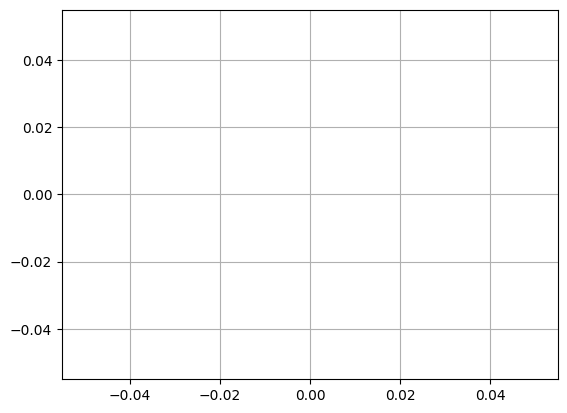

1.1739610433578491


KeyboardInterrupt: 

In [10]:
BCE = nn.BCELoss()
MSE = nn.MSELoss()
LogSoftmax = nn.LogSoftmax()
losses = []
slosses = []

for _ in trange(400000):
    
    # Supervised Learning
    x, yt1, yt2 = next(bg)
    x, yt1, yt2 = np2t(x, yt1, yt2)
    yp = net(x)
    yp = yp * x[:,:,:,[1]] + 0.5 * (1-x[:,:,:,[1]])
    loss = BCE(yp.view(-1), yt1.view(-1))
    loss2 = -torch.mean(torch.sum(LogSoftmax(net.res_ships) * yt2, axis=[1]))
    losses += [loss.item()]
    (loss+loss2).backward()
        
    # Semisupervised Learning
    x, _, _ = next(bg)
    x = np2t(x)
    with torch.no_grad():
        y = teacher(x)
    x, y = augment(x, y)
    y2 = net(x)
    sloss = 50*MSE(y, y2)
    sloss.backward()
    slosses += [sloss.item()]
    
    optimizer.step()
    optimizer.zero_grad()
    update_mt(teacher, net, tau)
    
    if len(losses) == 100:
        #print(np.mean(losses))
        print(np.mean(slosses))
        net.losses.append((net.iters, np.mean(losses)))
        losses = []
        slosses = []
        
    if net.iters % 100 == 0:
        plt.plot(*zip(*net.losses))
        #plt.ylim([0.58, 0.6])
        plt.grid()
        plt.show()
        print(loss2.item())
        
    if net.iters % 1000 == 0:
        with open('data/__battleships_unet.dat', 'wb') as f:
            torch.save(net.state_dict(), f)
        
    net.iters += 1
        

In [ ]:
net.losses

In [ ]:
sea = njit_create_sea()
#det = create_detection()
det = np.random.rand(10,10) < 0.75
prob = net.predict(encode_x(sea, det))
prob[det > 0] = 0
plt.imshow(visualize(sea, det))
plt.show()
plt.imshow(prob, vmax=1.)
plt.colorbar()
plt.show()

In [ ]:
sea = njit_create_sea()
prob = net.predict(encode_x(sea, det))
plt.imshow(prob)

In [ ]:
sea = np.zeros((10,10))
det = np.zeros((10,10))
while np.any(1-det):
    prob = net.predict(encode_x(sea, det))
    prob[det > 0] = 0
    ij = np.random.choice(range(100), p=prob.flatten()/np.sum(prob))
    i, j = divmod(ij, 10)
    det[i,j] = 1
    sea[i,j] = 1 if np.random.rand()<prob[i,j] else 0

    #plt.imshow(visualize(sea, det))
    #plt.show()
    #plt.imshow(prob, vmax=1.)
    #plt.show()
    
plt.imshow(visualize(sea, det))

### AI spielt

In [ ]:
from vidcapture import *

In [ ]:
# gegeben: sea, model
det = np.zeros((10,10))
sea = create_sea(100)
##det = create_detection()
i,j = [],[]
#vc = vidcapture('F:/$Daten/vidcaptures/battleships cnn/frame%05d.png')

while True:
    prob = net.predict(encode_x(sea, det))
    prob[det > 0] = 0
    percent = 0. if np.sum(det)==0 else 100*np.sum(det*sea)/(np.sum(det)+1e-2)
    text = f'Hits: %d, Shots: %d, Percentage: %.1f %%' % (np.sum(det*sea), np.sum(det), percent)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    ax1.title.set_text('Map')
    ax2.title.set_text('Neural Network prediction')
    ##fig.text(1/2,0.8, text, fontdict={})
    ax1.axis('off')
    #ax1.imshow(visualize(sea, det), vmin=0., vmax=3.)
    plot_sea(sea, det, ax1)
    ax1.scatter(j, i, c='black', alpha=1, s=150)
    ax2.axis('off')
    ax2.imshow(prob)
    #plt.title(text)
    #vc.capture()
    plt.show()
    
    if np.sum(det*sea) >= np.sum(sea): break
        
    # Welchen Detektieren??
    m = prob.argmax()
    i, j = m//10, m%10
    det[i,j] = 1.

    

In [ ]:

# Viele Spiele spielen und score sehen
from bs_gameclass import *

rs = []
for _ in trange(100):
    s = GameState()
    h = create_sea()
    r = 0
    while not GameClass.getEnded(s):
        prob = net.predict(encode_x(s.sea, s.det))
        prob[s.det==1] = 0
        ij = argmax2d(prob)
        s = GameClass.getNextState(s, ij, h)
        r += h[ij]*np.mean(1-s.det)
        #plot_state(s)
        #plt.show()
    rs.append(r)

In [ ]:
import seaborn as sns
plt.hist(rs)
np.mean(rs), np.std(rs)